In [2]:
## imports
import sys
import glob, os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
import cmocean as cmo
import xesmf as xe

import datetime
import time
import math
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xskillscore
import matplotlib as mpl
import scipy
from matplotlib.gridspec import GridSpec
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import cartopy.mpl.ticker as cticker
import matplotlib.ticker as mticker

from defs import regularAtlmask, lon180, amocstrength_100yr

## MMM SSS plots without HadGEM3

In [3]:
folder = ''
modellist =  ['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM5A', 'IPSL-CM5A2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F']#,'HadGEM3']

model = 'CESM1.2'
ds = xr.open_dataset(folder+model+'/Eoi400/'+'SST_annual_100yr.nc')
ds = lon180(ds)

#Compute weights for SST averaging
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

def preprocessing(ds): 
    ds = lon180(ds)
    return ds.expand_dims(dim='model')

paths = []
for i in range(len(modellist)):
    paths.append(folder+modellist[i]+'/E280/'+'SSS_100yr.nc')
    
dsE280 = xr.open_mfdataset(paths, concat_dim='model',combine='nested', preprocess = preprocessing)
sssE280 = dsE280.sss.where(dsE280.sss.count(dim='model')>10) #Only show SSS where more than 10 models indicate ocean grid cells
mmmE280 = sssE280.mean(dim='model')

paths = []
for i in range(len(modellist)):
    paths.append(folder+modellist[i]+'/Eoi400/'+'SSS_100yr.nc')
    
dsEoi400 = xr.open_mfdataset(paths, concat_dim='model',combine='nested', preprocess = preprocessing)
sssEoi400 = dsEoi400.sss.where(dsEoi400.sss.count(dim='model')>10) #Only show SSS where more than 10 models indicate ocean grid cells
mmmEoi400 = sssEoi400.mean(dim='model')

In [5]:
# #Uncomment to save arrays that contain SSS of all models, as well as the land-sea mask extracted the SSS
## to do this, first include HadGEM3 in the modellist

# xr.DataArray.to_netcdf(sssE280, path = '/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/sssE280.nc')
# xr.DataArray.to_netcdf(sssEoi400, path = '/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/sssEoi400.nc')

# mask = mmmEoi400*0+1
# xr.DataArray.to_netcdf(mask, path = '/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/1x1oceanmaskEoi400.nc')

# mask = mmmE280*0+1
# xr.DataArray.to_netcdf(mask, path = '/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/1x1oceanmaskE280.nc')

In [6]:
#Arrays that count how many models show the same + or - sign for Eoi400-E280
count_pos = mmmEoi400.where((sssEoi400-sssE280)>0).count(dim='model')
count_neg = mmmEoi400.where((sssEoi400-sssE280)<0).count(dim='model')

#Construct 2D arrays of longitude and latitude to produce scatter plots for significance (>= 12 models agree on sign)
lon = dsE280.lon
lat = dsE280.lat

coords = xr.Dataset(data_vars = dict(lat2D=(["lat", "lon"], np.repeat(lat.values[:, np.newaxis], len(lon), axis=1))), coords = dict(lat = lat.values, lon = lon.values))
coords['lon2D'] = coords.lat2D.copy(deep=True)
coords.lon2D[:] = np.transpose(np.repeat(lon.values[:, np.newaxis], len(lat), axis=1))

threshold = 12
mask_pos = count_pos.where(count_pos>=threshold)
mask_neg = count_neg.where(count_neg>=threshold)


/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/regionmask/core/plot.py:12: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  coords += [np.asarray(p.exterior)[:, :2]] + [


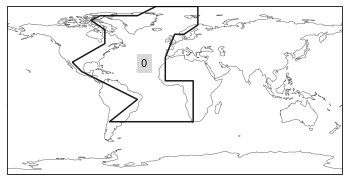

In [7]:
#Create Atlantic mask to exclude points in Mediterranean and North Sea
import regionmask
model = 'CCSM4'
Atlantic = np.array([[-110,30],[-75,50],[-75, 65],[-90,75],[-80,80],[-40,80], [-20,90], [25,90], [25,80], [25,70],[10,60],[0,60],[-10,35], [-10,10], [20,10], [20,-34], [-70,-34], [-40, -10], [-70,5], [-100,20]])
region = regionmask.Regions([Atlantic])

ax = region.plot()
ax.set_extent([0, 350, -90, 90], crs=ccrs.PlateCarree())

# define lat/ lon grid
ds = xr.open_dataset(folder+model+'/Eoi400/'+'SST_annual_100yr.nc')
ds = lon180(ds)

mask_Atl_reg = region.mask(ds.lon.values, ds.lat.values)

#Uncomment line below to save this Atlantic mask
#xr.DataArray.to_netcdf(mask_Atl_reg, path = '/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/1x1Atlmask.nc')

In [8]:
#Compute zonal mean change in SSS for Atlantic and standard deviation of zonal mean change
zmsss = mmmEoi400.where(mask_Atl_reg>-1).mean(dim='lon')-mmmE280.where(mask_Atl_reg>-1).mean(dim='lon')
stdsss = (dsEoi400.sss.where(mask_Atl_reg>-1).mean(dim='lon')-dsE280.sss.where(mask_Atl_reg>-1).mean(dim='lon')).std(dim='model')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


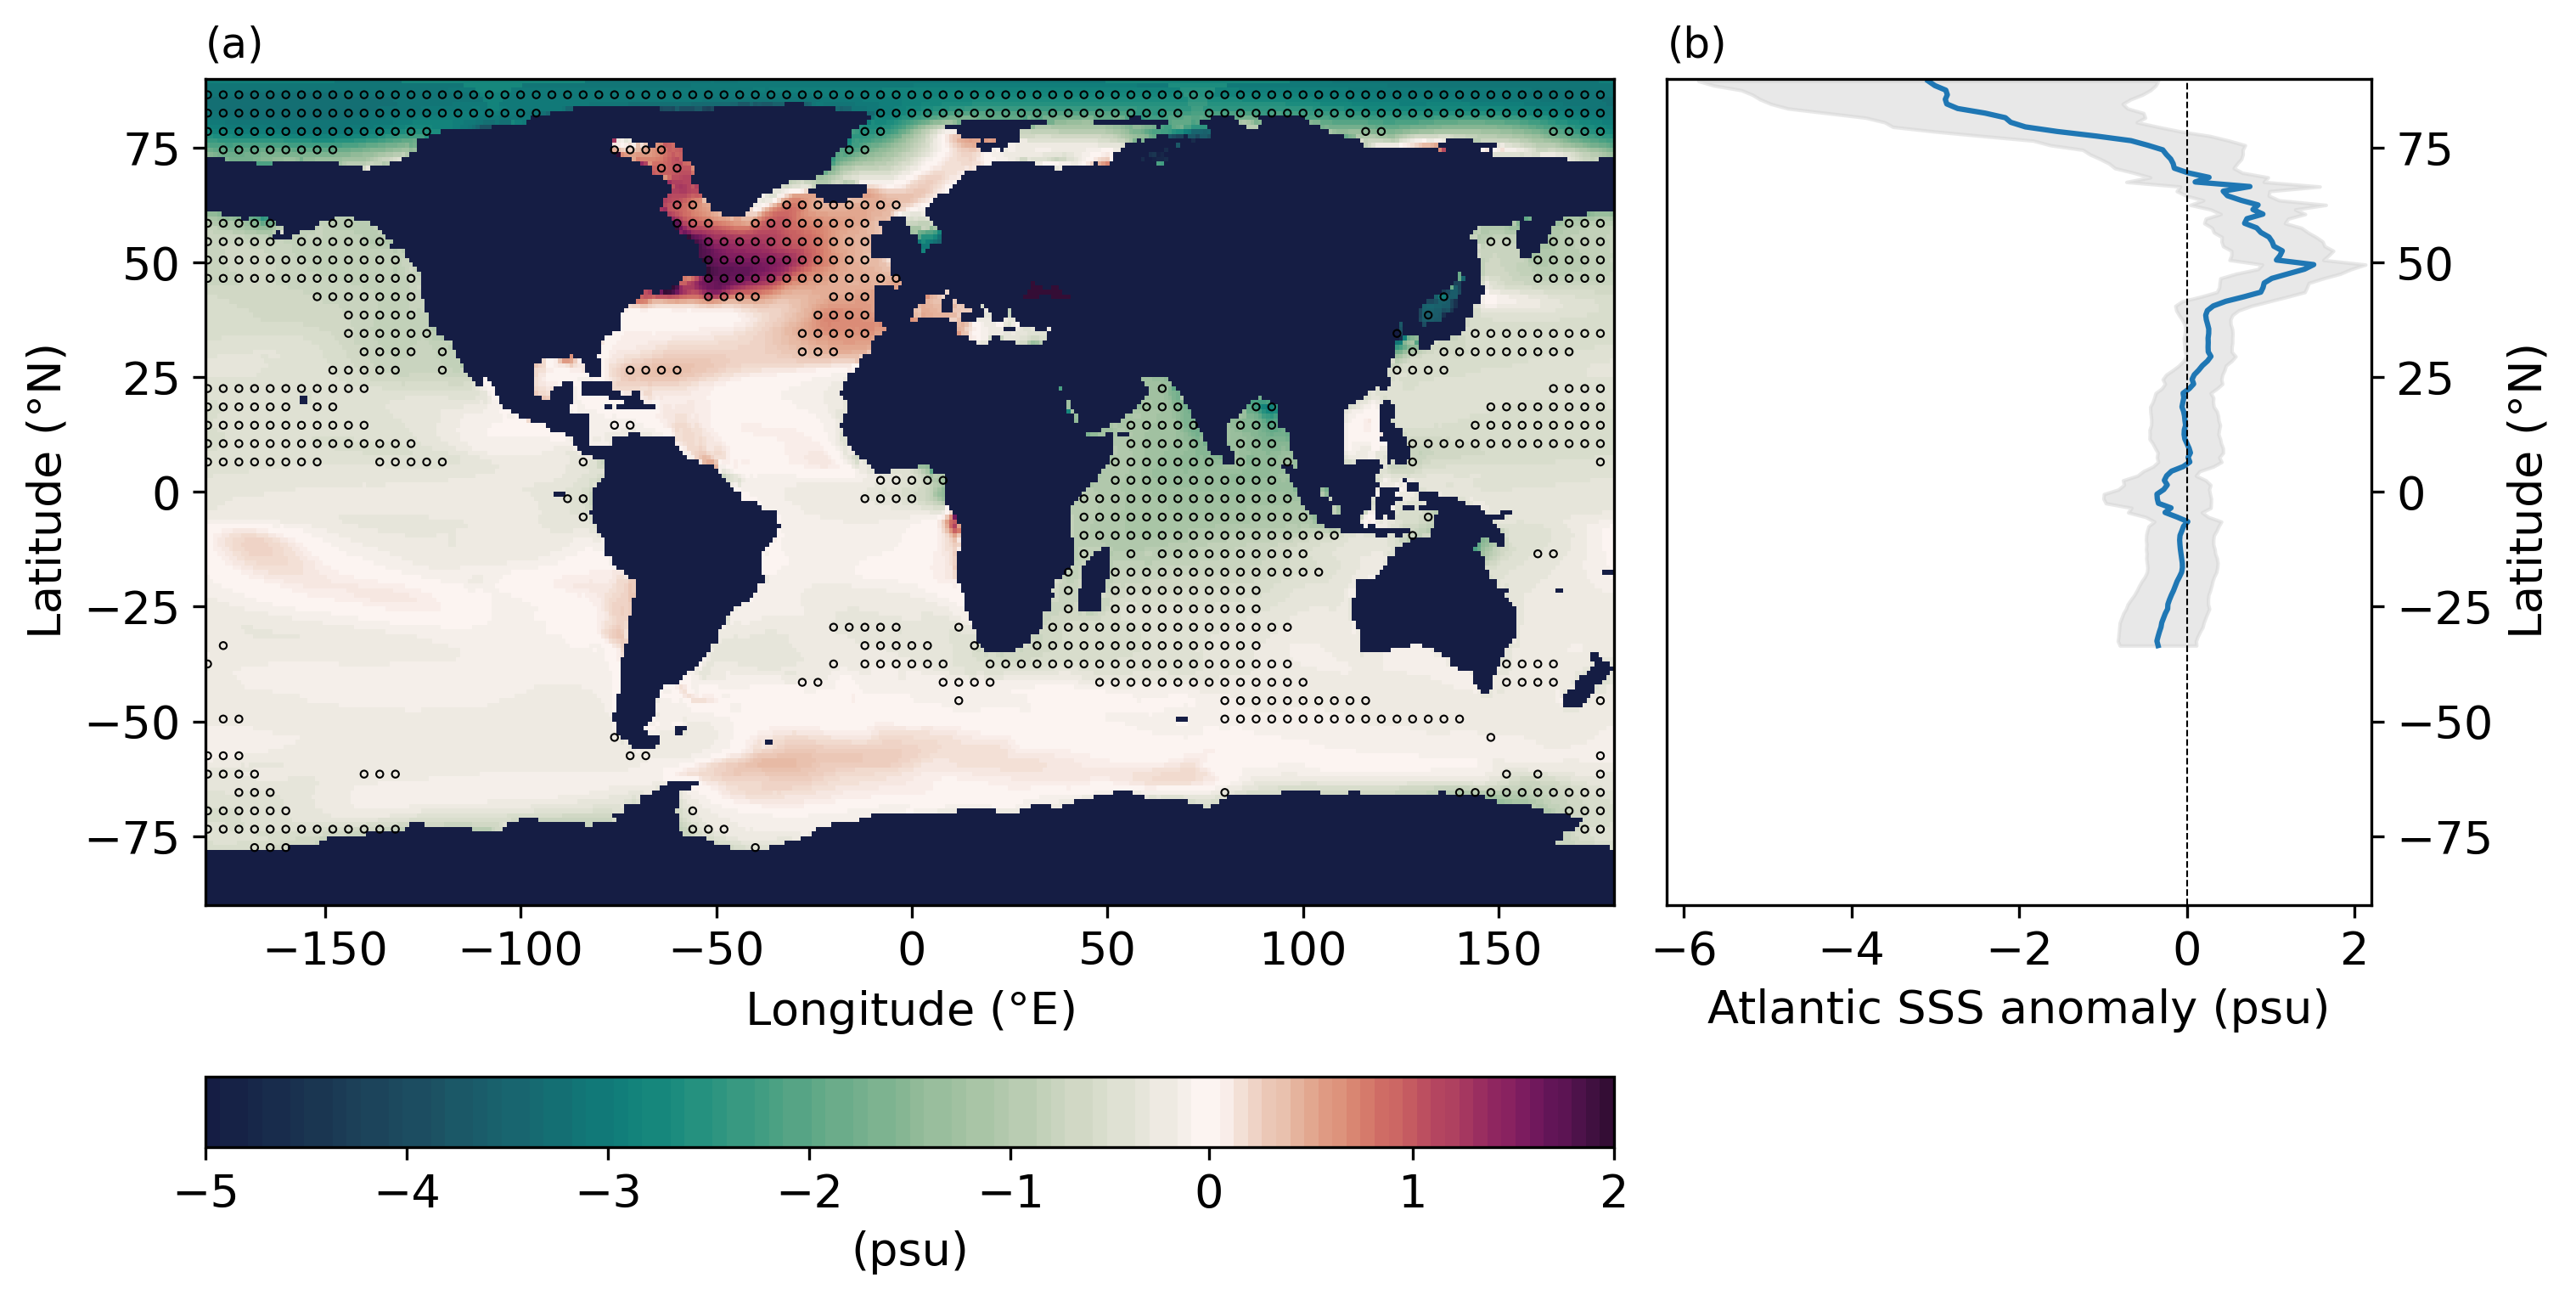

In [9]:
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13
plt.rcParams['axes.labelsize'] = 13

fig1 = fig = plt.figure(figsize=(10,5),dpi=300, constrained_layout=True)
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0:2])

divnorm = colors.TwoSlopeNorm(vmin=-5., vcenter=0, vmax=2)
cmap1 = plt.get_cmap('cmo.curl',100)
cmap1.set_under('darkgrey')

im = ax1.pcolormesh(dsE280.lon, dsE280.lat, (mmmEoi400-mmmE280).fillna(-100), cmap=cmap1, shading='auto', norm=divnorm)
cs1 = ax1.scatter(coords.lon2D.where(mask_pos>0)[::4,::4], coords.lat2D.where(mask_pos>0)[::4,::4], s=4, facecolors='none', edgecolors='black', linewidth=0.5)
cs2 = ax1.scatter(coords.lon2D.where(mask_neg>0)[::4,::4], coords.lat2D.where(mask_neg>0)[::4,::4], s=4, facecolors='none', edgecolors='black', linewidth=0.5)
ax1.set_title('(a)', loc='left')
ax1.set_xlabel('Longitude ($\degree$E)')
ax1.set_ylabel('Latitude ($\degree$N)')
fig1.colorbar(im, ax = ax1, orientation='horizontal', label = '(psu)')

ax2 = fig.add_subplot(gs[0, 2])
ax2.plot(zmsss, dsE280.lat)
ax2.plot([0,0],[-90,90], linewidth=0.5, linestyle = '--', color='black')
ax2.fill_betweenx(dsE280.lat, zmsss-stdsss, zmsss+stdsss, color='lightgrey', alpha=0.5)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_ylim([-90,90])
ax2.set_xlim([-6.2,2.2])
ax2.set_title('(b)', loc='left')
ax2.set_xlabel('Atlantic SSS anomaly (psu)')
ax2.set_ylabel('Latitude ($\degree$N)')
plt.savefig('fig05.png', bbox_inches='tight')

## MMM PmE plot and scatter of PmE with AMOC strength

In [8]:
#Store SSS from previous section
dsE280sss = dsE280.copy(deep=True)
dsEoi400sss = dsEoi400.copy(deep=True)
mmmE280sss = mmmE280.copy(deep=True)
mmmEoi400sss = mmmEoi400 .copy(deep=True)

#Open PmE fields from Han et al.(2021) and interpolate to 1x1 grid from SSS
#All PmE fields are contained in a single folder, unlike all other variables which in separate model folders
folder = ''
modellist =  ['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM5A', 'IPSL-CM5A2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F','HadGEM3']

ds = lon180(xr.open_dataset(folder+'/'+modellist[0]+'.'+ 'PI' + '.PmE.12monthly.r144x73.nc', decode_times=False))

dsE280 = xr.Dataset(data_vars = dict(pme=(["model", "lat", "lon"], np.zeros([len(modellist),len(ds.lat), len(ds.lon)]))), coords = dict(model = modellist, lat = ds.lat.values, lon = ds.lon.values))
dsEoi400 = xr.Dataset(data_vars = dict(pme=(["model", "lat","lon"], np.zeros([len(modellist),len(ds.lat), len(ds.lon)]))), coords = dict(model = modellist, lat = ds.lat.values, lon = ds.lon.values))


experiment = 'PI' #experiment = 'Plio'
for i in range(0,len(modellist)):
    model = modellist[i]
    ds = lon180(xr.open_dataset(folder+'/'+model+'.'+ experiment + '.PmE.12monthly.r144x73.nc', decode_times=False))
    if model == 'IPSL-CM5A' or model == 'IPSL-CM5A2':
        dsE280.pme[i] = ds.PmE.mean(dim='time_counter')
    elif model == 'HadCM3':
        dsE280.pme[i] = ds.PmE.mean(dim='t')
    elif model == 'MIROC4m':
        dsE280.pme[i] = ds.PmE
    else:
        dsE280.pme[i] = ds.PmE.mean(dim='time')

    
experiment = 'Plio' #experiment = 'Plio'
for i in range(0,len(modellist)):
    model = modellist[i]
    ds = lon180(xr.open_dataset(folder+'/'+model+'.'+ experiment + '.PmE.12monthly.r144x73.nc', decode_times=False))
    if model == 'IPSL-CM5A' or model == 'IPSL-CM5A2':
        dsEoi400.pme[i] = ds.PmE.mean(dim='time_counter')
    elif model == 'HadCM3':
        dsEoi400.pme[i] = ds.PmE.mean(dim='t')
    elif model == 'MIROC4m':
        dsEoi400.pme[i] = ds.PmE
    else:
        dsEoi400.pme[i] = ds.PmE.mean(dim='time')

regridder = xe.Regridder(dsE280, dsE280sss, 'bilinear', periodic = True, ignore_degenerate=True)

#Compute MMM without HadGEM3
mmmE280 = regridder(dsE280.pme[:-1].mean(dim='model'))
mmmEoi400 = regridder(dsEoi400.pme[:-1].mean(dim='model'))


/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [9]:
#Atlantic PmE anomaly in 50-65N and west of 30W
regridder = xe.Regridder(dsE280, dsE280sss, 'bilinear', periodic = True, ignore_degenerate=True)
Epme = regridder(dsE280.pme)
Eoipme = regridder(dsEoi400.pme)

weights = np.cos(np.deg2rad(Epme.lat)) #Use latitudinal weights for averaging
weights.name = "weights"

Atlpme = (Eoipme-Epme).where(mask_Atl_reg>-1).where(Epme.lat>=40).where(Epme.lat<=65).where(Epme.lon<=-30).weighted(weights).mean(dim=['lat','lon'])

In [10]:
#AMOC anomaly
folder = '/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/'

amocE = np.zeros(len(modellist))
amocEoi = np.zeros(len(modellist))

for i in range(len(modellist)):
    model = modellist[i]    
    amocE[i] = amocstrength_100yr(model, 'E280')
    amocEoi[i] = amocstrength_100yr(model, 'Eoi400')
    
difamoc = amocEoi-amocE

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/opt/anaconda3/envs/myenv/lib/python3.

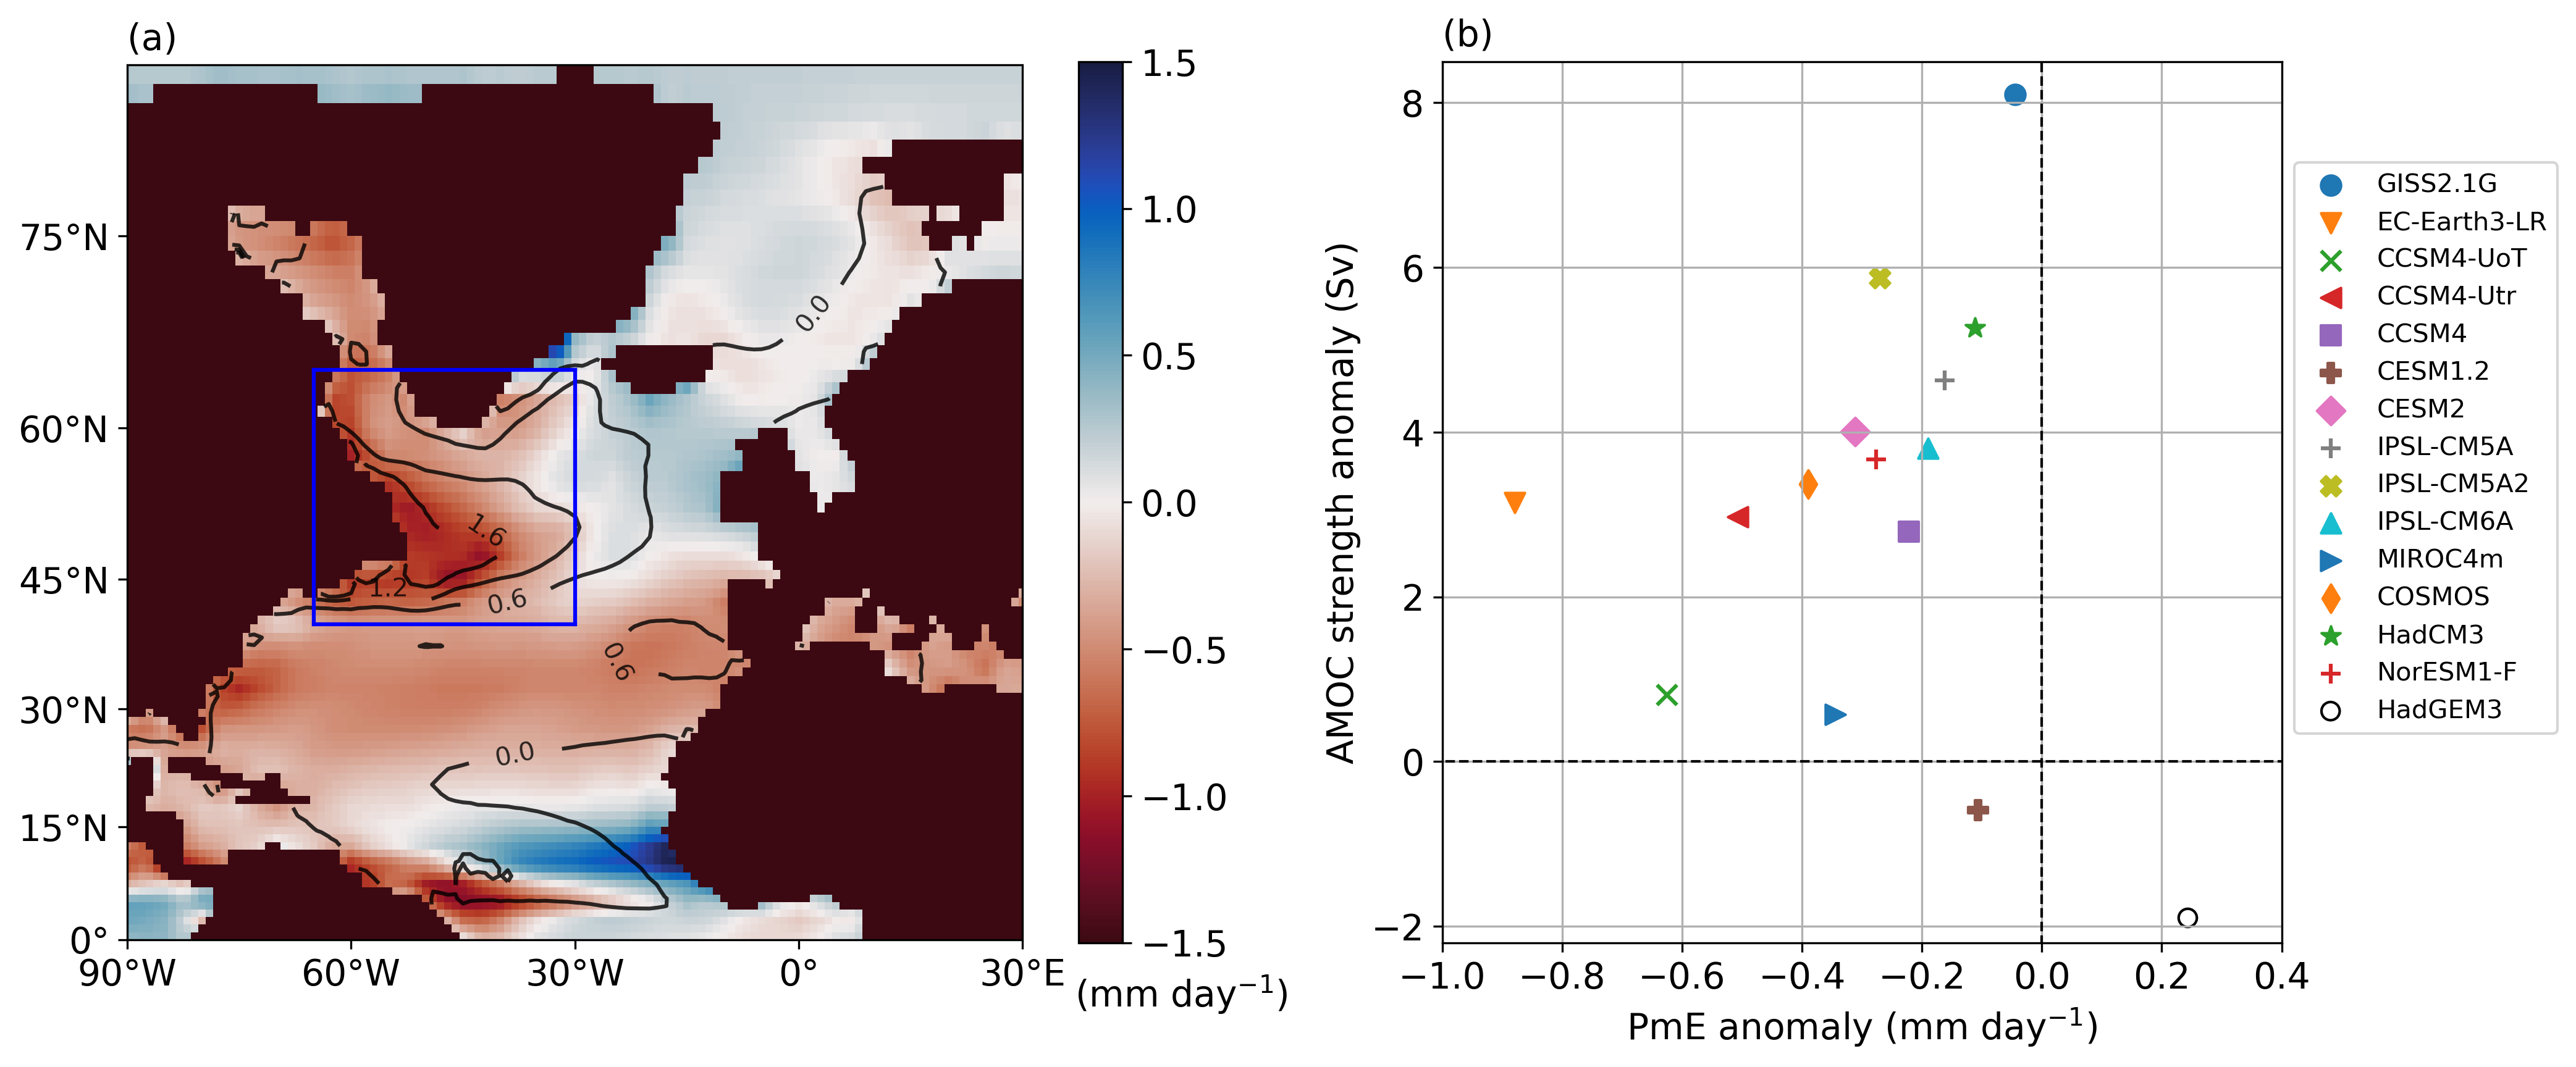

In [11]:
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.rcParams['axes.labelsize'] = 14

markers = ["o","v","x","<","s","P","D","+","X","^",">","d","*","+","o"]
divnorm = colors.TwoSlopeNorm(vmin=-1.5, vcenter=0, vmax=1.5)

fig = plt.figure(figsize=(15,6.3),dpi=300)
gs = GridSpec(1, 2, width_ratios=[4, 3], height_ratios=[1])

ax1 = fig.add_subplot(gs[0], projection = ccrs.Miller())
im = ax1.pcolormesh(dsE280sss.lon, dsE280sss.lat, (mmmEoi400-mmmE280).where(mmmEoi400sss<1e30).fillna(-1000), transform = ccrs.PlateCarree(), cmap='cmo.balance_r', shading='auto', norm=divnorm)
cp = ax1.contour(dsE280sss.lon, dsE280sss.lat, (mmmEoi400sss-mmmE280sss), transform = ccrs.PlateCarree(), colors=['k','k','k','k'], levels=[0, 0.6, 1.2, 1.6], alpha=0.8, zorder=1)
ax1.clabel(cp, inline=True, inline_spacing=0.1, fmt = '%.1f',  fontsize=10)

ax1.plot([-65,-30],[65, 65], transform = ccrs.PlateCarree(), color='b')
ax1.plot([-65,-30],[40, 40], transform = ccrs.PlateCarree(), color='b')
ax1.plot([-65,-65],[40, 65], transform = ccrs.PlateCarree(), color='b')
ax1.plot([-30,-30],[40, 65], transform = ccrs.PlateCarree(), color='b')

ax1.set_extent([-90, 30, 20, 85], ccrs.PlateCarree())
ax1.set_title('(a)', loc='left', fontsize=14)
fig1.colorbar(im, ax = ax1, orientation='vertical')
ax1.text(37,-9,'(mm day$^{-1}$)', fontsize=14)

ax1.set_xticks(np.arange(-90,31,30), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)

ax1.set_yticks(np.arange(0,80,15), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)

ax2 = fig.add_subplot(gs[1])

for j in range(0,len(modellist)-1):
    scatter = ax2.scatter(Atlpme[j], difamoc[j], s=60, c = 'C'+str(j), label=modellist[j], marker=markers[j])

scatter = ax2.scatter(Atlpme[-1], difamoc[-1], s=50, facecolors='none', edgecolors = 'k', label=modellist[-1], marker=markers[-1])
ax2.plot([-30, 60], [0, 0], color='black',linewidth =1, linestyle ='--')
ax2.plot([0, 0], [-50, 150], color='black',linewidth =1, linestyle ='--')
ax2.set_xlim([-1,0.4])
ax2.set_ylim([-2.2,8.5])
ax2.grid()
ax2.set_title('(b)', loc='left', fontsize=14)
ax2.set_xlabel('PmE anomaly (mm day$^{-1}$)')
ax2.set_ylabel('AMOC strength anomaly (Sv)')
ax2.legend(bbox_to_anchor=(1., 0.90), fontsize=10.)
plt.savefig('fig08.png', bbox_inches='tight')

In [12]:
## Uncomment to store regridded PmE for all models in single files for E280 and Eoi400
# regridder = xe.Regridder(dsE280, dsE280sss, 'bilinear', periodic = True, ignore_degenerate=True)
# Epme = regridder(dsE280.pme).where(mmmE280sss<1e30)
# Eoipme = regridder(dsEoi400.pme).where(mmmEoi400sss<1e30)

# xr.DataArray.to_netcdf(Epme, path = '/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/PmEE280.nc')
# xr.DataArray.to_netcdf(Eoipme, path = '/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/PmEEoi400.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
